In [3]:
%pylab inline
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, cross_validation
import scipy, scipy.stats, matplotlib
import statsmodels.formula.api as sm
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
analytic_base = pd.read_csv('~/Repositories/datasets/analytic_base.csv')
analytic_qgiv = pd.read_csv('~/Repositories/datasets/analytic_qgiv_stats.csv')

ab = analytic_base[['id', 'org', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol']]
aq = analytic_qgiv[['id', 'base', 'org', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha']]
d = pd.merge(ab, aq, left_on="id", right_on="base")

In [5]:
# filter out not visited observations
data = d[d.visits > 0]
# add conversion
conversion = pd.DataFrame({'conversion':data["don_form_trans_count"]/data["total_visits"]*100})
# merge conversion w/ the rest of the data
data = pd.concat([data, conversion], axis=1)
# add day_of_month & month
date_data = pd.DataFrame({
        'day': pd.to_datetime(data.timestamp).apply(lambda x: x.day), 
        'month': pd.to_datetime(data.timestamp).apply(lambda x: x.month)})
# merge date data w/ the rest of the data
data = pd.concat([data, date_data], axis=1)

# add restrictionsXmultirestriction interaction term, restrictions^2, opt_fields^2, req_fields^2
data['restrictionsXmultirestriction'] = data.restrictions*data.multirestriction_system
data['restrictions2'] = data.restrictions*data.restrictions
data['restrictions2Xmultirestriction'] = data.restrictions2*data.multirestriction_system
data['restrictions3'] = data.restrictions*data.restrictions*data.restrictions
data['restrictions3Xmultirestriction'] = data.restrictions3*data.multirestriction_system
data['opt_fields2'] = data.opt_fields*data.opt_fields
data['req_fields2'] = data.req_fields*data.req_fields
data['fields'] = data['opt_fields'] + data['req_fields']
data['fields2'] = data['fields']*data['fields']

## StatsModels OLS analysis

In [6]:
features = data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# normalize features
features_scaled = preprocessing.scale(features)

/Users/vsquared/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [7]:
features.columns.values

array(['opt_fields', 'req_fields', 'donation_active',
       'multirestriction_system', 'restrictions', 'pledges_count',
       'pledge_active', 'permit_anonymous', 'permit_mobile',
       'permit_other_amount', 'enable_donorlogins', 'collect_captcha',
       'day', 'month', 'restrictionsXmultirestriction', 'restrictions2',
       'restrictions2Xmultirestriction', 'restrictions3',
       'restrictions3Xmultirestriction', 'opt_fields2', 'req_fields2',
       'fields', 'fields2'], dtype=object)

In [8]:
data['Eins'] = np.ones((len(data), ))

Y = data.conversion[:-1]
X = features_scaled[:-1]
fit = sm.OLS(Y, X).fit()
print fit.summary()

del data['Eins']

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     625.5
Date:                Wed, 14 Sep 2016   Prob (F-statistic):               0.00
Time:                        16:19:28   Log-Likelihood:            -2.3568e+06
No. Observations:              569721   AIC:                         4.714e+06
Df Residuals:                  569699   BIC:                         4.714e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          4.633e+12   5.48e+10     84.478      0.0

# Restriction model testing

In [9]:
mdl = linear_model.LinearRegression()
mdl.fit(features, data.conversion)
mdl_scaled = linear_model.LinearRegression()
mdl_scaled.fit(features_scaled, data.conversion)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

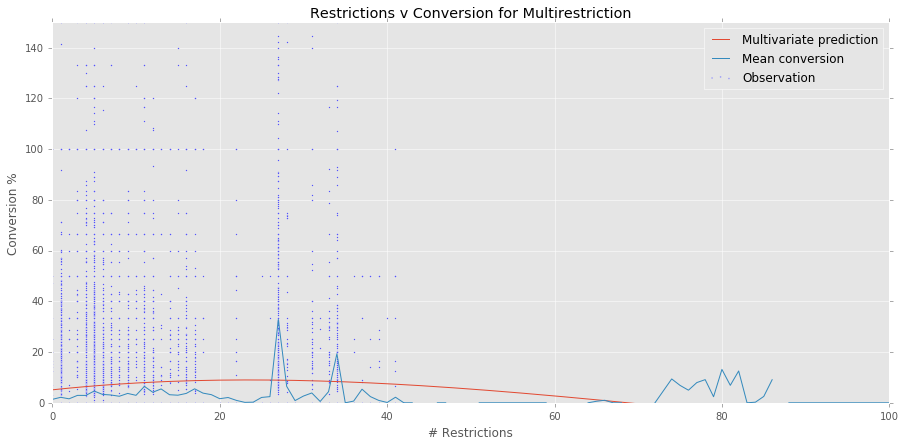

SCALED COEFFICIENTS
opt_fields: 3276513882.76
req_fields: 1701060766.74
donation_active: 0.574618816376
multirestriction_system: 0.713469028473
restrictions: 1.49554443359
pledges_count: 0.124914288521
pledge_active: -0.387669146061
permit_anonymous: -0.063366651535
permit_mobile: 0.17988088727
permit_other_amount: 0.0487137064338
enable_donorlogins: 0.364709332585
collect_captcha: 114.780723035
day: 0.18301653862
month: -0.150677453727
restrictionsXmultirestriction: 0.850797392428
restrictions2: -3.48924241215
restrictions2Xmultirestriction: -1.03295908868
restrictions3: 2.02395896614
restrictions3Xmultirestriction: 0.637960616499
opt_fields2: 0.0239956229925
req_fields2: 0.0386029817164
fields: -3873404322.6
fields2: -0.20668374002


In [10]:
# generate prediction data
example = data[data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['restrictions'] = i
    example['restrictionsXmultirestriction'] = i
    example['restrictions2'] = i*i
    example['restrictions2Xmultirestriction'] = i*i
    example['restrictions3'] = i*i*i
    example['restrictions3Xmultirestriction'] = i*i*i
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(data[data.restrictions==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(data[data.multirestriction_system==1.0].restrictions, data[data.multirestriction_system==1.0].conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Restrictions v Conversion for Multirestriction")
xlim(0, 100)
ylim(0, 150)
xlabel('# Restrictions')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])

In [11]:
mr_data = data[data.multirestriction_system == 1.0]
mr_data = mr_data[mr_data.restrictions > 20]
mr_data = mr_data[mr_data.restrictions < 30]
print len(mr_data)
print len(mr_data[mr_data.org_x==29705])
print len(mr_data[mr_data.org_x==911])
mr_data[['org_x', 'form', 'timestamp', 'restrictions', 'conversion']].head()

1526
517
731


,org_x,form,timestamp,restrictions,conversion
781,29705,94263,2015-03-21 04:00:01,27.0,15.789474
1521,911,894,2015-03-22 04:00:01,22.0,0.000000
2317,29705,94263,2015-03-22 04:00:01,27.0,38.461538
3114,29705,94263,2015-03-21 16:00:01,27.0,90.909091
3291,911,894,2015-03-21 16:00:01,22.0,0.000000


## Removing higher restriction counts

Trying a re-train removing all restrictions > 20. 

Outliers w/ high restrictions & high conversion:
* org: 29705, form: 94263
* org: 911, form: 894

In [12]:
# removing 2 outlier forms 
data = data[data.restrictions < 20]

In [13]:
features = data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# normalize features
features_scaled = preprocessing.scale(features)

mdl = linear_model.LinearRegression()
mdl.fit(features, data.conversion)
mdl_scaled = linear_model.LinearRegression()
mdl_scaled.fit(features_scaled, data.conversion)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

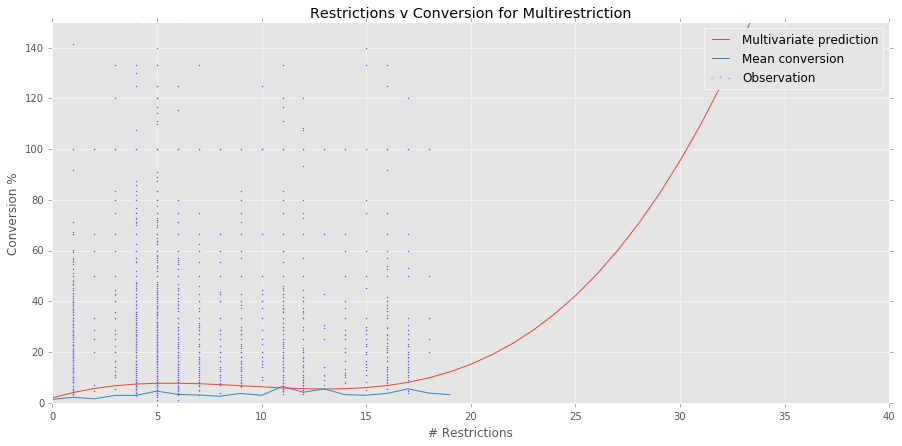

SCALED COEFFICIENTS
opt_fields: 1026609576.43
req_fields: 509427704.477
donation_active: 0.551968574524
multirestriction_system: -0.0443609952927
restrictions: 0.157040715218
pledges_count: 0.165357887745
pledge_active: -0.377574622631
permit_anonymous: -0.0874398648739
permit_mobile: 0.0972695872188
permit_other_amount: -0.0208189338446
enable_donorlogins: 0.327967889607
collect_captcha: 453.265498812
day: 0.183952675201
month: -0.150516889989
restrictionsXmultirestriction: 4.31553898193
restrictions2: 1.30464825593
restrictions2Xmultirestriction: -6.69084948115
restrictions3: -0.984336532652
restrictions3Xmultirestriction: 3.37161086593
opt_fields2: -0.511380814016
req_fields2: -0.202996585518
fields: -1188138394.94
fields2: 0.488579943776


In [14]:
# generate prediction data
example = data[data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['restrictions'] = i
    example['restrictionsXmultirestriction'] = i
    example['restrictions2'] = i*i
    example['restrictions2Xmultirestriction'] = i*i
    example['restrictions3'] = i*i*i
    example['restrictions3Xmultirestriction'] = i*i*i
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(data[data.restrictions==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(data[data.multirestriction_system==1.0].restrictions, data[data.multirestriction_system==1.0].conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Restrictions v Conversion for Multirestriction")
xlim(0, 40)
ylim(0, 150)
xlabel('# Restrictions')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])

In [15]:
m_data = data[data.multirestriction_system==1.0].copy()
print "Total multirestriction observations: "+str(len(m_data))
len(m_data[m_data.restrictions>17])

Total multirestriction observations: 40552


117

In [16]:
for i in m_data.restrictions.unique():
    i_m_data = m_data[m_data.restrictions==i].copy().sort("conversion", ascending=False)
    if len(m_data[m_data.restrictions==i]) > 0:
        ten_prc = int(len(i_m_data) / 10)
        print "dropping "+str(ten_prc)+" rows; original: "+str(len(i_m_data))+", new: "+str(len(i_m_data[ten_prc:]))
        del m_data[m_data.restrictions==i]
        m_data.append(i_m_data[ten_prc:])

dropping 345 rows; original: 3455, new: 3110


/Users/vsquared/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


TypeError: '[ True False False ..., False False False]' is an invalid key

In [ ]:
print (len(m_data))
m_data[m_data.restrictions==2]

In [ ]:
print(len(test_data))

In [ ]:
test_data.drop(test_data[test_data.conversion > 150], axis=1)

In [ ]:
print(len(test_data))

In [ ]:
test_data[:10]